In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data as torch_data

import io
from google.colab import files

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Download our dataset from digital model

In [0]:
#uploaded = files.upload()

df = pd.read_csv('dataset1.csv')

In [142]:
df.nunique()

Unnamed: 0                   64000
comb_T                       63990
comb_P                       63990
cp_T                         63992
cp_P                         63992
ct_T                         63992
ct_P                         63992
lpc_pr                       63986
lpc_mfr                      63988
hpc_pr                       63988
hpc_mfr                      63990
lpt_pr                       63989
lpt_mfr                      63992
hpt_pr                       63989
hpt_mfr                      63989
hpc_h                        63994
iso_lpc                      63991
iso_hpc                      63994
iso_lpt                      63993
iso_hpt                      63991
LPC_rpm                      63992
HPC_rpm                      63990
lpc_mfr_cor                  63988
hpc_mfr_cor                  63992
pressure_after_turbine       63990
temperature_after_turbine    63993
HPC_T                        63994
Power                        63993
lpc                 

In [0]:
df.drop('Unnamed: 0', axis=1, inplace=True)  # Drop column with all unique values
df.drop(['iso_lpc','iso_hpc','iso_lpt','iso_hpt','lpc','hpc','lpt','hpt',
         'lpc_cond','hpc_cond','lpt_cond','hpt_cond','condition'], 
         axis=1, inplace=True) # Drop columns with extra targets and non sensor data

In [144]:
df.isna().sum().sum()  # No NAN values

0

In [145]:
df

,comb_T,comb_P,cp_T,cp_P,ct_T,ct_P,lpc_pr,lpc_mfr,hpc_pr,hpc_mfr,lpt_pr,lpt_mfr,hpt_pr,hpt_mfr,hpc_h,LPC_rpm,HPC_rpm,lpc_mfr_cor,hpc_mfr_cor,pressure_after_turbine,temperature_after_turbine,HPC_T,Power,state
0,1267.662579,1.463859e+06,448.761322,362104.793974,1180.811482,753253.912457,3.704916,44.205535,3.751988,58.807007,2.857217,66.182892,1.862949,65.176608,728591.436644,6025.263904,10617.562939,44.972336,20.470107,264502.021094,1134.483813,670.835695,1.196676e+07,0
1,1267.642015,1.463938e+06,448.767483,362121.686853,1180.766005,753307.398782,3.705088,44.207791,3.752020,58.809633,2.857327,66.188949,1.862918,65.180738,728604.088742,6025.388127,10617.683115,44.974631,20.470207,264510.783143,1134.434444,670.845798,1.196778e+07,0
2,1267.625281,1.464017e+06,448.773607,362138.525128,1180.725959,753359.860645,3.705259,44.210067,3.752051,58.812258,2.857433,66.194759,1.862889,65.184757,728616.668142,6025.512374,10617.803427,44.976946,20.470309,264519.555116,1134.390648,670.855842,1.196882e+07,0
3,1267.612117,1.464095e+06,448.779695,362155.304375,1180.690957,753411.367415,3.705429,44.212364,3.752083,58.814876,2.857536,66.200338,1.862862,65.188674,728629.193842,6025.636631,10617.923862,44.979284,20.470410,264528.336068,1134.352022,670.865844,1.196988e+07,0
4,1267.602258,1.464173e+06,448.785749,362172.032182,1180.660634,753461.982419,3.705599,44.214679,3.752116,58.817492,2.857634,66.205702,1.862837,65.192494,728641.656313,6025.760888,10618.044409,44.981639,20.470513,264537.125195,1134.318199,670.875795,1.197096e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,1027.219663,1.656052e+06,475.993813,428459.139240,977.552263,884526.436802,4.051997,51.527820,4.177075,32.505112,2.919295,84.223955,1.943197,85.474110,811229.721465,6329.212973,11022.138845,52.421635,9.848283,302401.197906,935.012527,735.958673,1.266156e+07,15
63996,1072.531768,1.292972e+06,466.212723,384340.359400,1027.780994,696843.603139,3.639036,42.139690,3.655410,25.223212,2.951146,65.255416,1.939800,66.384012,758611.459916,5954.776053,10117.498571,42.870656,8.431291,235426.889514,986.549767,694.685990,8.333791e+06,15
63997,1375.482627,1.286069e+06,441.602353,337051.017948,1284.040815,660241.832750,3.451744,39.321510,3.509592,53.477401,2.774779,55.733919,1.850307,54.716184,716302.757429,5812.256699,10191.122959,40.003592,19.838460,238975.449575,1237.017076,661.002189,1.027660e+07,15
63998,1089.030963,1.521885e+06,476.213282,405267.891337,1019.452908,786440.189360,4.168274,42.971197,3.468718,60.726423,3.109328,74.007758,1.857246,72.927438,767931.798095,6220.096482,10455.164284,43.716587,19.456014,253573.812306,980.799196,702.043841,1.004365e+07,15


In [0]:
X = df.drop('state', axis=1)
y = df.state
y = np.array(y)

## We have balanced dataset (4000 samples of each class)

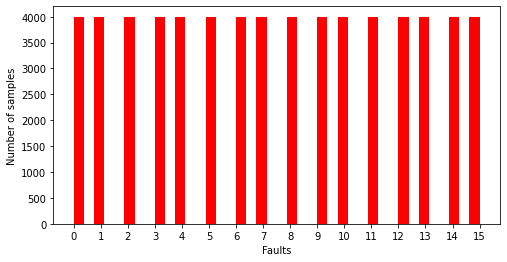

In [147]:
plt.figure(figsize=(8, 4))
sns.distplot(y, kde=False, hist_kws={"histtype": "bar", "alpha": 1, "color": "r"})
plt.xticks(np.arange(16))
plt.xlabel('Faults')
plt.ylabel('Number of samples')
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Try different classifiers. Choose best hyperparameters using Grid Search CV

## 1.1 Logistic Regression

In [0]:
recall_metric = make_scorer(recall_score, average='macro')
f1_metric = make_scorer(f1_score, average='macro')

In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [46]:
lr = LogisticRegression(random_state=0, n_jobs=-1)

parameters = {'max_iter': [100, 1000],
             'solver': ('saga', 'lbfgs')}

lr_grid = GridSearchCV(lr, parameters, n_jobs=-1, scoring=recall_metric)
lr_grid.fit(X_train_sc, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_iter': [100, 1000], 'solver': ('saga', 'lbfgs')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(recall_score, average=macro), verbose=0)

In [47]:
lr_grid.best_params_

{'max_iter': 1000, 'solver': 'lbfgs'}

In [48]:
print('CV')
print(f'Recall Score: {round(lr_grid.best_score_, 2)}\n')  

lr_pred_test = lr_grid.predict(X_test_sc)
f1 = f1_score(y_test, lr_pred_test, average='macro')  # Set macro cause we have balanced dataset
recall = recall_score(y_test, lr_pred_test, average='macro')
print('Test')
print(f'F1 Score: {round(f1, 2)}') 
print(f'Recall Score: {round(recall, 2)}')  

CV
Recall Score: 0.5

Test
F1 Score: 0.49
Recall Score: 0.51


## 1.2 Random Forest

In [50]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=0)

parameters = {'n_estimators': [100, 200]}

rfc_grid = GridSearchCV(rfc, parameters, n_jobs=-1, scoring=recall_metric)
rfc_grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=0,
                                  

In [51]:
rfc_grid.best_params_

{'n_estimators': 200}

In [52]:
print('CV')
print(f'Recall Score: {round(rfc_grid.best_score_, 2)}\n')  

rfc_pred_test = rfc_grid.predict(X_test)
f1 = f1_score(y_test, rfc_pred_test, average='macro')  # Set macro cause we have balanced dataset
recall = recall_score(y_test, rfc_pred_test, average='macro')
print('Test')
print(f'F1 Score: {round(f1, 2)}') 
print(f'Recall Score: {round(recall, 2)}')   

CV
Recall Score: 0.84

Test
F1 Score: 0.86
Recall Score: 0.86


# 1.3 XGBoost

In [17]:
xgb = XGBClassifier(n_jobs=-1, random_state=0)

parameters = {'n_estimators': [100, 200]}

xgb_grid = GridSearchCV(xgb, parameters, n_jobs=-1, scoring=recall_metric)
xgb_grid.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_estimators': [100, 200]}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
             scoring=make_scorer(recall_score

In [18]:
xgb_grid.best_params_

{'n_estimators': 200}

In [19]:
print('CV')
print(f'Recall Score: {round(xgb_grid.best_score_, 2)}\n')  

xgb_pred_test = xgb_grid.predict(X_test)
f1 = f1_score(y_test, xgb_pred_test, average='macro')  # Set macro cause we have balanced dataset
recall = recall_score(y_test, xgb_pred_test, average='macro')
print('Test')
print(f'F1 Score: {round(f1, 2)}') 
print(f'Recall Score: {round(recall, 2)}')  

CV
Recall Score: 0.64

Test
F1 Score: 0.63
Recall Score: 0.64


## Look at feature importances of Random Forest and XGBoost

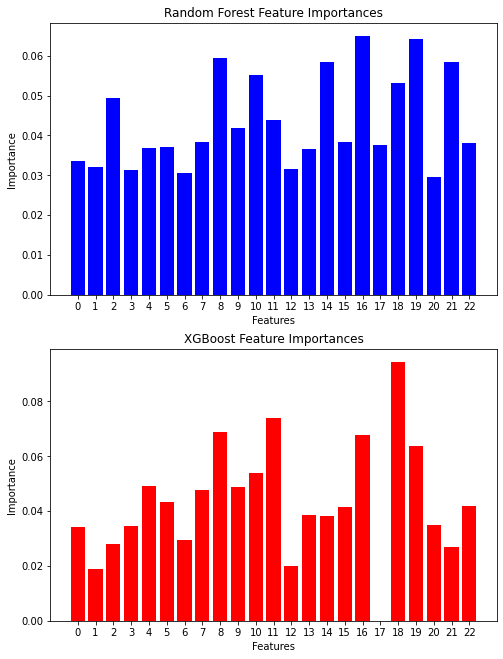

In [24]:
plt.figure(figsize=(8, 11))
plt.subplot(2, 1, 1, title='Random Forest Feature Importances')
plt.bar(range(len(rfc_grid.best_estimator_.feature_importances_)), rfc_grid.best_estimator_.feature_importances_, color='b')
plt.xticks(np.arange(23))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.subplot(2, 1, 2, title='XGBoost Feature Importances')
plt.bar(range(len(xgb_grid.best_estimator_.feature_importances_)), xgb_grid.best_estimator_.feature_importances_, color='r')
plt.xticks(np.arange(23))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [22]:
print('TOP 5 Important features')
print(f'Random Forest: {df.columns[8]}, {df.columns[14]}, {df.columns[16]}, {df.columns[19]}, {df.columns[21]}')
print(f'XGBoost: {df.columns[8]}, {df.columns[11]}, {df.columns[16]}, {df.columns[18]}, {df.columns[19]}')

TOP 5 Important features
Random Forest: hpc_pr, hpc_h, HPC_rpm, pressure_after_turbine, HPC_T
XGBoost: hpc_pr, lpt_mfr, HPC_rpm, hpc_mfr_cor, pressure_after_turbine


# 2. Let's add more samples in our dataset to improve scores. Generate new dataset with double number of samples

In [5]:
#uploaded = files.upload()

df = pd.read_csv('dataset2.csv')

Saving dataset2.csv to dataset2.csv


In [0]:
df.drop('Unnamed: 0', axis=1, inplace=True)  # Drop column with all unique values
df.drop(['iso_lpc','iso_hpc','iso_lpt','iso_hpt','lpc','hpc','lpt','hpt',
         'lpc_cond','hpc_cond','lpt_cond','hpt_cond','condition'], 
         axis=1, inplace=True) # Drop columns with extra targets and non sensor data

In [6]:
df

,comb_T,comb_P,cp_T,cp_P,ct_T,ct_P,lpc_pr,lpc_mfr,hpc_pr,hpc_mfr,lpt_pr,lpt_mfr,hpt_pr,hpt_mfr,hpc_h,LPC_rpm,HPC_rpm,lpc_mfr_cor,hpc_mfr_cor,pressure_after_turbine,temperature_after_turbine,HPC_T,Power,state
0,1121.027843,1.934155e+06,487.873435,478373.384656,1044.646799,1.003484e+06,4.907747,55.089967,3.762197,74.301834,3.273320,92.415420,1.859505,91.120411,799886.187358,6740.722638,11061.622656,56.045572,20.412854,307165.977698,1000.103213,727.113808,1.570970e+07,0
1,1101.383705,1.870613e+06,492.110673,494532.925591,1045.666471,1.005638e+06,4.697406,59.573568,4.064708,40.431138,3.237030,92.247843,1.927962,93.562618,816039.485023,6731.737265,11084.829831,60.606947,10.791201,310056.123884,998.939700,739.700788,1.571000e+07,0
2,1109.103883,1.896016e+06,490.765034,479028.642282,1033.890420,9.846720e+05,4.917318,53.762339,3.678097,73.187783,3.339362,91.115776,1.856296,89.800167,799882.209366,6726.338005,10961.258241,54.694915,20.138704,295451.880607,990.144751,727.110702,1.459269e+07,0
3,1100.530500,1.865636e+06,494.667665,501878.625921,1045.583185,1.005125e+06,4.766531,59.492935,3.997239,40.091410,3.331660,92.162160,1.924854,93.477161,816640.028508,6753.830286,11010.961657,60.524915,10.571266,301089.696111,998.756246,740.167690,1.529860e+07,0
4,1120.458011,1.930078e+06,490.297768,485135.163941,1044.498869,1.002869e+06,4.977630,54.972848,3.699776,74.413869,3.363508,92.328929,1.855676,91.000313,800307.446760,6763.132397,10990.911469,55.926422,20.208715,298776.721417,999.933626,727.442770,1.518896e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143995,1063.510524,1.763751e+06,478.423445,428033.259154,995.515189,9.108743e+05,4.404672,48.922843,3.819567,67.832610,2.996195,86.198059,1.865729,84.936331,793775.911248,6445.483863,11042.091107,49.771472,20.624568,304784.873872,954.807136,722.337921,1.341034e+07,15
143996,1101.185335,1.867740e+06,493.936740,468112.502238,1027.204847,9.683570e+05,4.806724,52.614410,3.708553,71.643203,3.181053,89.951373,1.860509,88.666748,810829.787386,6673.395553,11043.706947,53.527073,20.238487,304980.118958,984.338210,735.647298,1.464006e+07,15
143997,1088.513867,1.818307e+06,504.883789,496549.122701,1034.916405,9.784412e+05,4.712881,57.599550,3.939633,38.442922,3.214185,90.197375,1.926815,91.493049,838729.397078,6709.709599,11034.013730,58.598687,10.350647,303814.187739,989.395570,757.291254,1.480181e+07,15
143998,1092.494351,1.828604e+06,501.689217,507964.477742,1039.883169,9.877018e+05,4.819288,58.261364,3.879304,38.362387,3.408822,90.769847,1.922236,92.123935,836533.815388,6754.575068,10901.707900,59.271981,10.064849,289122.151469,993.959859,755.593517,1.437336e+07,15


In [0]:
X = df.drop('state', axis=1)
y = df.state
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

# Train the best classifier on bigger dataset

In [0]:
rfc = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
y_pred_test = rfc.predict(X_test)
f1 = f1_score(y_test, y_pred_test, average='macro')  # Set macro cause we have balanced dataset
recall = recall_score(y_test, y_pred_test, average='macro')
print('Test')
print(f'F1 Score: {round(f1, 2)}') 
print(f'Recall Score: {round(recall, 2)}')   

Test
F1 Score: 0.93
Recall Score: 0.93


## As we notice, Recall has considerably increased with bigger dataset!!! 

# 3. Try to Implement Neural Network Using PyTorch (code from HW2)

# 3.1 First, plot our dataset in 2D using Latent Space from Autoencoder

In [0]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [0]:
class Data(torch_data.Dataset):
    def __init__(self, X, y):
        super(Data, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [0]:
train_dset = Data(X_train_sc, y_train) 
test_dset = Data(X_test_sc, y_test) 

In [0]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        x_out = self.decoder(self.encoder(x))
        return x_out

In [0]:
in_dim = 23

encoder = lambda hidden: nn.Sequential(
                                        nn.Linear(in_dim, in_dim*3),
                                        nn.LeakyReLU(inplace=True),
                                        nn.Linear(in_dim*3, in_dim*2),
                                        nn.LeakyReLU(inplace=True),
                                        nn.Linear(in_dim*2, hidden)
                                      )  

decoder = lambda hidden: nn.Sequential(
                                        nn.Linear(hidden, in_dim*2),
                                        nn.LeakyReLU(inplace=True),
                                        nn.Linear(in_dim*2, in_dim*3),
                                        nn.LeakyReLU(inplace=True),
                                        nn.Linear(in_dim*3, in_dim)
                                      )

In [0]:
device = torch.device('cpu')

net = AE(encoder(2), decoder(2))  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.7) 

train_loader = torch_data.DataLoader(train_dset, batch_size=100, shuffle=True) 
test_loader = torch_data.DataLoader(test_dset, batch_size=200, shuffle=False) 

In [0]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save_dir=None):
    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, _ in train_loader:
            # Perform one step of minibatch stochastic gradient descent            
            X = X.to(device)
            out = net(X)
            loss = criterion(out, X)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        net.eval()
        for X, _ in val_loader:
            
            # Compute the validation loss            
            X = X.to(device)
            out = net(X)
            val_loss = criterion(out, X)
         
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))

In [19]:
train(100, net, criterion, optimizer, train_loader, test_loader, scheduler) 

Epoch 5/100 || Loss:  Train 0.0098 | Validation 0.0081
Epoch 10/100 || Loss:  Train 0.0085 | Validation 0.0076
Epoch 15/100 || Loss:  Train 0.0055 | Validation 0.0065
Epoch 20/100 || Loss:  Train 0.0050 | Validation 0.0057
Epoch 25/100 || Loss:  Train 0.0049 | Validation 0.0068
Epoch 30/100 || Loss:  Train 0.0033 | Validation 0.0049
Epoch 35/100 || Loss:  Train 0.0057 | Validation 0.0056
Epoch 40/100 || Loss:  Train 0.0039 | Validation 0.0059
Epoch 45/100 || Loss:  Train 0.0035 | Validation 0.0047
Epoch 50/100 || Loss:  Train 0.0063 | Validation 0.0044
Epoch 55/100 || Loss:  Train 0.0038 | Validation 0.0042
Epoch 60/100 || Loss:  Train 0.0062 | Validation 0.0041
Epoch 65/100 || Loss:  Train 0.0040 | Validation 0.0044
Epoch 70/100 || Loss:  Train 0.0052 | Validation 0.0042
Epoch 75/100 || Loss:  Train 0.0028 | Validation 0.0041
Epoch 80/100 || Loss:  Train 0.0055 | Validation 0.0036
Epoch 85/100 || Loss:  Train 0.0051 | Validation 0.0036
Epoch 90/100 || Loss:  Train 0.0050 | Validation 

In [0]:
tr_dset = net.encoder(train_dset[:][0]).detach().numpy()
tt_dset = net.encoder(test_dset[:][0]).detach().numpy()

## Let's get the picture of faults in latent space

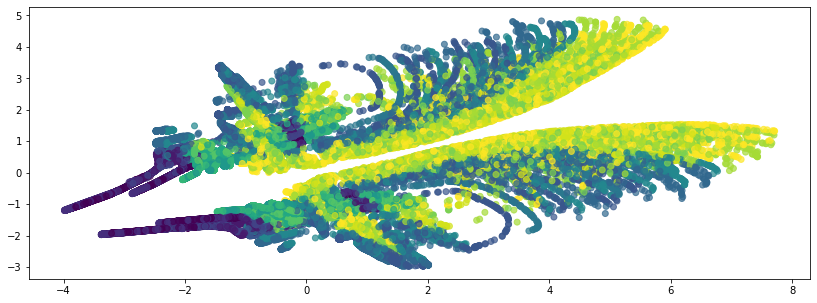

In [32]:
plt.figure(figsize=(8, 5))
plt.scatter(tr_dset[:,0], tr_dset[:,1], c=train_dset[:][1], alpha=0.7)
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.show()

# 3.2 Implement Multi Layer Perceptron 



In [0]:
np.random.seed(0)

input_size = in_dim
hidden_dim_size = 80
number_of_classes = 16

mlp = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)

criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.001)
scheduler_mlp = torch.optim.lr_scheduler.StepLR(optimizer_mlp, step_size=200, gamma=0.7) 

def train_MLP(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save_dir=None):
    net.to(device)
    
    learning_curve = [0] * epochs
    test_curve = [0] * epochs
    recall_curve = [0] * epochs
    f1_curve = [0] * epochs

    max_val_recall = 0
    max_val_recall_epoch = 0
    for epoch in tqdm(range(epochs)):
        net.train()
        f1_train, recall_train = [], []
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent  
            y = y.to(device=device, dtype=torch.int64)
            X = X.to(device)
            out = net(X)
            loss = criterion(out, y)
            f1_train.append(f1_score(y.detach().numpy(), 
                            np.argmax(torch.log_softmax(out, dim=1).detach().numpy(), axis=1),
                            average='macro'))
            
            recall_train.append(recall_score(y.detach().numpy(),
                            np.argmax(torch.log_softmax(out, dim=1).detach().numpy(), axis=1), 
                            average='macro'))
            learning_curve[epoch] += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #learning_curve[epoch] /= X_train_sc.shape[0]
        net.eval()       

        f1 = []
        recall = []
        for X, y in val_loader:
            y = y.to(device=device, dtype=torch.int64)
            # Compute the validation loss            
            X = X.to(device)
            out = net(X)
            val_loss = criterion(out, y)

            f1.append(f1_score(y.detach().numpy(), 
                               np.argmax(torch.log_softmax(out, dim=1).detach().numpy(), axis=1), average='macro'))
            recall.append(recall_score(y.detach().numpy(),
                                       np.argmax(torch.log_softmax(out, dim=1).detach().numpy(), axis=1), average='macro'))
            test_curve[epoch] += val_loss.item()

        val_recall = recall[-1]
        recall_curve[epoch] += recall[-1]
        f1_curve[epoch] += f1[-1]

        if val_recall > max_val_recall:
            max_val_recall = val_recall
            max_val_recall_epoch = epoch   
            
        if scheduler is not None:
            scheduler.step()
                       
        freq = max(epochs//10,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, loss.item(), val_loss.item()))
            print('f1_train: ',np.mean(f1_train), ' test: ', np.mean(f1))
            print('recall_train: ',np.mean(recall_train),' test: ', np.mean(recall),'\n')
   
    print('Max Recall: ', max_val_recall)
    print('Max Recall Epoch: ', max_val_recall_epoch)

    plt.figure(figsize=(8, 4))        
    plt.plot(learning_curve,label='train')
    plt.plot(test_curve, label='test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Softmax crossentropy loss')
    plt.show()

    plt.figure(figsize=(8, 4))        
    plt.plot(recall_curve, label='Recall')
    plt.plot(f1_curve, label='F1')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/100 || Loss:  Train 0.9589 | Validation 0.9346
f1_train:  0.36972595546401643  test:  0.4773718158189907
recall_train:  0.4311138125248921  test:  0.5166395589810988 

Epoch 10/100 || Loss:  Train 0.4698 | Validation 0.4301
f1_train:  0.7744460412194303  test:  0.801106279356275
recall_train:  0.7915593092085061  test:  0.8087456301962818 

Epoch 20/100 || Loss:  Train 0.4302 | Validation 0.4689
f1_train:  0.8184676126047622  test:  0.7751492640523668
recall_train:  0.8328847529114329  test:  0.7908924356778938 

Epoch 30/100 || Loss:  Train 0.3076 | Validation 0.2906
f1_train:  0.8421917903743102  test:  0.8562740289717825
recall_train:  0.8546957569246705  test:  0.8618751247297277 

Epoch 40/100 || Loss:  Train 0.2386 | Validation 0.2478
f1_train:  0.8543302949810189  test:  0.8766957850976175
recall_train:  0.8662000270123824  test:  0.8826615769817148 

Epoch 50/100 || Loss:  Train 0.1541 | Validation 0.2254
f1_train:  0.8661950873317811  test:  0.8765002483016128
recall_t

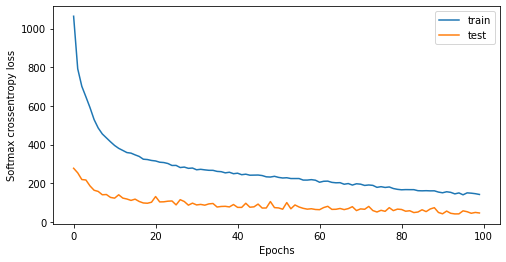

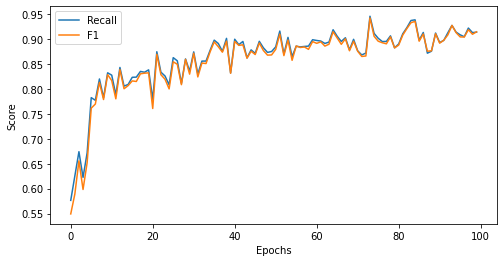

In [19]:
train_MLP(100, mlp, criterion_mlp, optimizer_mlp, train_loader, test_loader, scheduler_mlp)

# 4. Add Stacking (code from HW2)

In [0]:
clf1 = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, random_state=0)
clf2 = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
clf3 = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf4 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf5 = XGBClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf6 = XGBClassifier(n_estimators=200, n_jobs=-1, random_state=0)
final = XGBClassifier(n_jobs=-1, random_state=0)

clfs = [clf1, clf2, clf3, clf4, clf5, clf6]

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

In [0]:
def meta_classifier(base_clfs, final_classifier, X_train, X_test, y_train, cv):
    """
    Meta classifier prediction using stacking. 
    Input:
    :param base_clfs: list,  base classifiers which will be stacked together.
    :param final_classifier: estimator, a classifier which will be used to combine the base estimators. 
    :param X_train: numpy array or pandas table, train set.
    :param X_test: numpy array or pandas table, target for train set.
    :param X_train: numpy array or pandas table, test set.
    
    Output:
    :param y_pred: numpy array or pandas table, prediction of meta classifier using stacking on test set.
    :param final_classifier(optional): estimator, trained final_calssifier.
    
    More details https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
    
    """
    skf = StratifiedKFold(n_splits=cv, random_state=0)
    train = np.array(list(skf.split(X_train, y_train)))
    X, y = train[:, 0], train[:, 1]
    dataset_blend_train = np.zeros((X_train.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((X_test.shape[0], len(clfs)))

    for j, clf in enumerate(base_clfs):
        for i, (train, test) in enumerate(zip(X, y)):
            X_train_ = X_train.iloc[train]
            y_train_ = y_train.iloc[train]
            X_test_ = X_train.iloc[test]
            y_test_ = y_train.iloc[test]
            clf.fit(X_train_, y_train_)
            y_pred = clf.predict(X_test_)
            dataset_blend_train[test, j] = y_pred

        y_small_preds_test = clf.predict(X_test)
        dataset_blend_test[:, j] = y_small_preds_test        
        print('clf #' + str(j+1) + ' trained')
            
    final_classifier.fit(dataset_blend_train, y_train)
    y_preds = final_classifier.predict(dataset_blend_test)
    
    return y_preds, final_classifier

In [10]:
predictions, final_clf = meta_classifier(base_clfs=clfs, final_classifier=final, X_train=X_train, X_test=X_test, y_train=y_train, cv=5)

clf #1 trained
clf #2 trained
clf #3 trained
clf #4 trained
clf #5 trained
clf #6 trained


In [0]:
print('Recall score for Stacking: ', recall_score(y_test, predictions, average='macro'))
print('F1 score for Stacking: ', f1_score(y_test, predictions, average='macro'))

Recall score for Stacking:  0.9315146797531153
F1 score for Stacking:  0.9312539062541205


## Wonderful result, isn't it?